<a href="https://colab.research.google.com/github/VIVEKPATIL12/DS_Combined/blob/main/wetSubclassification_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [4]:
import zipfile

In [5]:
zip_ref = zipfile.ZipFile('/content/WetSubclassificationData.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

classes = ["Asphilt_wet","cobaltstone_wet","Concreate_wet","gravel_wet","Heavy_wet","muddy_wet","slight_wet"] # replace with your actual class names
data_dir = '/content/WetSubclassificationData'
train_dir = 'content/train/'
test_dir = 'content/test/'

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes:
    # Create class-specific train and test directories
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Get a list of all image files for this class
    image_files = os.listdir(os.path.join(data_dir, cls))

    # Split the files into train and test sets
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)  # 80% train, 20% test

    # Copy the train files into the train directory
    for file in train_files:
        shutil.copy(os.path.join(data_dir, cls, file), os.path.join(train_dir, cls, file))

    # Copy the test files into the test directory
    for file in test_files:
        shutil.copy(os.path.join(data_dir, cls, file), os.path.join(test_dir, cls, file))




In [7]:
# Train the Model
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import scipy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Define the data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    '/content/content/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')




Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [8]:
# Load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dense(7, activation="softmax")(headModel)  # Change the number here according to your number of classes

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them so they will not be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# # Train the model
# model.fit(train_generator, validation_data=test_generator, epochs=2)

# # Save the model
# model.save('model.h5')




58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

model.fit(train_generator, validation_data=test_generator, epochs=5, callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
 4/18 ━━━━━━━━━━━━━━━━━━━━ 5:40 24s/step - accuracy: 0.9557 - loss: 0.1812

KeyboardInterrupt: 

Found 560 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 388s 22s/step


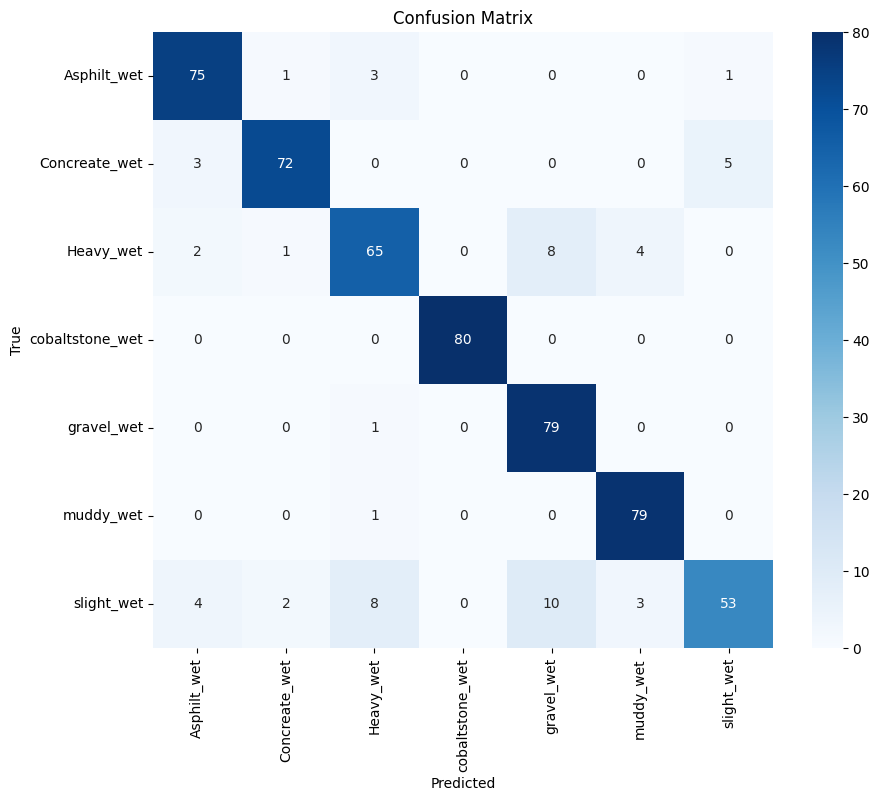

                 precision    recall  f1-score   support

    Asphilt_wet       0.89      0.94      0.91        80
  Concreate_wet       0.95      0.90      0.92        80
      Heavy_wet       0.83      0.81      0.82        80
cobaltstone_wet       1.00      1.00      1.00        80
     gravel_wet       0.81      0.99      0.89        80
      muddy_wet       0.92      0.99      0.95        80
     slight_wet       0.90      0.66      0.76        80

       accuracy                           0.90       560
      macro avg       0.90      0.90      0.90       560
   weighted avg       0.90      0.90      0.90       560



In [10]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = tf.keras.models.load_model('best_model.keras')

# Load the test data
test_generator = test_datagen.flow_from_directory(
    '/content/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Found 140 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 105s 19s/step


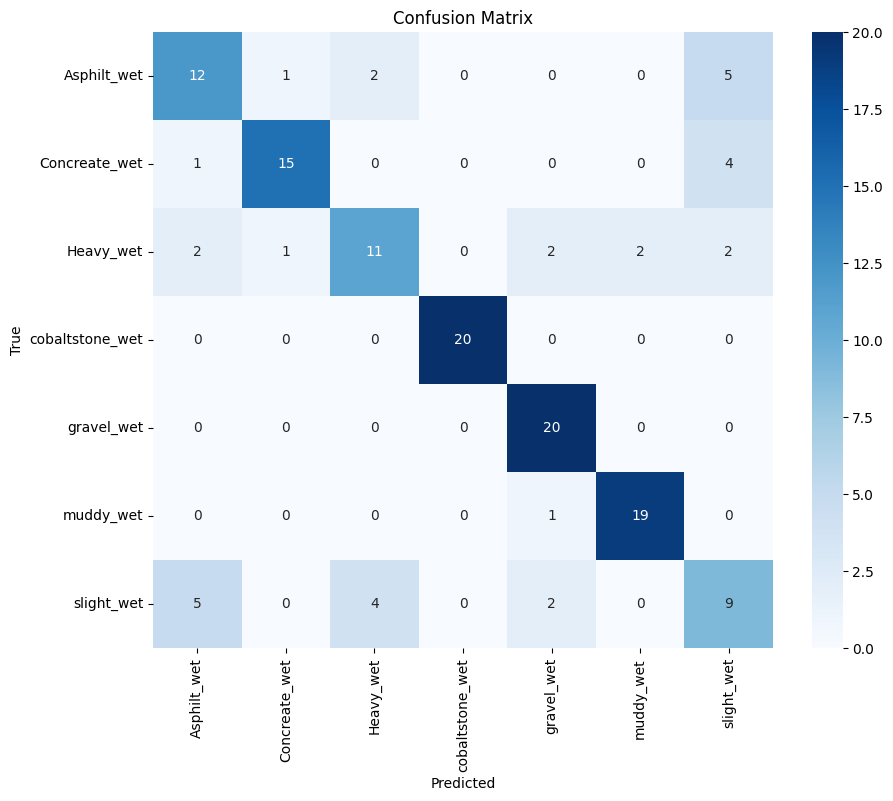

                 precision    recall  f1-score   support

    Asphilt_wet       0.60      0.60      0.60        20
  Concreate_wet       0.88      0.75      0.81        20
      Heavy_wet       0.65      0.55      0.59        20
cobaltstone_wet       1.00      1.00      1.00        20
     gravel_wet       0.80      1.00      0.89        20
      muddy_wet       0.90      0.95      0.93        20
     slight_wet       0.45      0.45      0.45        20

       accuracy                           0.76       140
      macro avg       0.75      0.76      0.75       140
   weighted avg       0.75      0.76      0.75       140



In [11]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = tf.keras.models.load_model('best_model.keras')

# Load the test data
test_generator = test_datagen.flow_from_directory(
    '/content/content/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))
